### Impact of Gaussian noise on waveform systematics
(
Figure 6)

In [1]:
import bilby
import matplotlib.pyplot as plt
import glob
import numpy as np
import h5py
import pandas as pd
from pesummary.utils.samples_dict import MultiAnalysisSamplesDict
from scipy.stats import gaussian_kde
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
from scipy.spatial.distance import jensenshannon
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 20
import config
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["BILBY_INCLUDE_GLOBAL_META_DATA"] = "1"

/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pesummary/gw/plots/plot.py:21: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MSUN_SI, PC_SI, CreateDict


In [2]:
#define JS divergence between 1D posterior distributions
def js_divergence_scipy(x1, x2, bins=100):
    # Shared bin range
    xmin = min(x1.min(), x2.min())
    xmax = max(x1.max(), x2.max())
    x_grid = np.linspace(xmin, xmax, bins)

    # KDE for both distributions
    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)
    p = kde1(x_grid)
    q = kde2(x_grid)

    # Normalize to turn into probability mass
    p /= p.sum()
    q /= q.sum()

    # Compute JS divergence between p and q
    js = jensenshannon(p, q, base=2) #base np.e to match pesummary
    return js * js

### Load PE samples
NRSUR, XPHM and XO4a

### GW231123

In [3]:
#Load GW231123 samples  (LVK release)
result_files_XPHM = config.gw231123_BF_XPHM
result_files_NRSUR = config.gw231123_BF_NRSUR
result_files_Xo4a = config.gw231123_BF_XO4a

XPHM = bilby.result.read_in_result(result_files_XPHM)
NRSUR = bilby.result.read_in_result(result_files_NRSUR)
XO4a = bilby.result.read_in_result(result_files_Xo4a)


In [4]:
params = ['mass_1_source', 'mass_2_source', 'a_1', 'a_2', 'chi_eff', 'chi_p', 'luminosity_distance', 'theta_jn', ]
param_to_str = {'total_mass':r'$M$', 'mass_1_source':r'$m_1$', 'mass_2_source':r'$m_2$', 'chi_eff':r'$\chi_{\rm{eff}}$', 'chi_p':r'$\chi_{\rm{p}}$', 'mass_ratio':r'$q$', 'luminosity_distance':r'$D_{\rm{L}}$', 'theta_jn':r'$\theta_{\mathrm{JN}}$', 'a_1':r'$\chi_1$', 'a_2':r'$\chi_2$'}

In [5]:
#JS divergence for GW231123 between NRSUR and XPHM
divergences = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    divs.append(js_divergence_scipy(XPHM.posterior[param], NRSUR.posterior[param]))
    divergences[param] = np.array(divs)
print("Done!")
print(divergences)

Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for luminosity_distance
Beginning calculations for theta_jn
Done!
{'mass_1_source': array([0.62204009]), 'mass_2_source': array([0.25203126]), 'a_1': array([0.10551077]), 'a_2': array([0.21625817]), 'chi_eff': array([0.39262849]), 'chi_p': array([0.01465488]), 'luminosity_distance': array([0.52307241]), 'theta_jn': array([0.26054731])}


In [6]:
#JS divergence for GW231123 between NRSUR and XO4a
divergences_XO4a = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    divs.append(js_divergence_scipy(XO4a.posterior[param], NRSUR.posterior[param]))
    divergences_XO4a[param] = np.array(divs)
print("Done!")
print(divergences_XO4a)

Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for luminosity_distance
Beginning calculations for theta_jn
Done!
{'mass_1_source': array([0.33492366]), 'mass_2_source': array([0.94478045]), 'a_1': array([0.12998631]), 'a_2': array([0.38653686]), 'chi_eff': array([0.07771191]), 'chi_p': array([0.13327494]), 'luminosity_distance': array([0.42647798]), 'theta_jn': array([0.79499469])}


### Zero noise simulation

In [7]:
#Load zero-noise results
result_0noise_NRSUR = config.maxLNRSUR_BF_NRSUR
result_0noise_XPHM = config.maxLNRSUR_BF_XPHM
result_0noise_XO4a = config.maxLNRSUR_BF_XO4a

result_0noise_NRSUR = bilby.result.read_in_result(result_0noise_NRSUR)
result_0noise_XPHM = bilby.result.read_in_result(result_0noise_XPHM)
noise_0_XO4a= bilby.result.read_in_result(result_0noise_XO4a)

In [8]:
#JS divergence between NRSur and XPHM zero-noise results
divergences_0noise = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    divs.append(js_divergence_scipy(result_0noise_XPHM.posterior[param], result_0noise_NRSUR.posterior[param]))
    divergences_0noise[param] = np.array(divs)
print("Done!")
print(divergences_0noise)

Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for luminosity_distance
Beginning calculations for theta_jn
Done!
{'mass_1_source': array([0.62391179]), 'mass_2_source': array([0.57237829]), 'a_1': array([0.04255288]), 'a_2': array([0.09707387]), 'chi_eff': array([0.03535673]), 'chi_p': array([0.14249965]), 'luminosity_distance': array([0.08874675]), 'theta_jn': array([0.16271796])}


In [9]:
#JS divergence between NRSur and XO4a zero-noise results
divergences_0noise_XO4a = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    divs.append(js_divergence_scipy(noise_0_XO4a.posterior[param], result_0noise_NRSUR.posterior[param]))
    divergences_0noise_XO4a[param] = np.array(divs)
print("Done!")
print(divergences_0noise_XO4a)

Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for luminosity_distance
Beginning calculations for theta_jn
Done!
{'mass_1_source': array([0.1614975]), 'mass_2_source': array([0.91303805]), 'a_1': array([0.13847978]), 'a_2': array([0.24389225]), 'chi_eff': array([0.20122645]), 'chi_p': array([0.08213541]), 'luminosity_distance': array([0.70315108]), 'theta_jn': array([0.69235167])}


In [10]:
#Load Gaussian noise simulations
result_files = {}

#for XPHM ------------------------------------------------------------------
result_files['XPHM'] = glob.glob(f"/home/sophie.bini/project/PE/231123_NR_simulatedNoise/maxL/XPHM_LH/outdir_XPHM_H1L1/final_result/maxL_injection_XPHM_H1L1_data*_1384782888-634277_analysis_H1L1_result.hdf5")
#for NRSUR -----------------------------------------------------------------
result_files['NRSUR'] = glob.glob(f"/home/sophie.bini/project/PE/231123_NR_simulatedNoise/maxL/NRSUR_LH/outdir_H1L1_nrsur/final_result/maxL_injection_H1L1_nrsur_data*_1384782888-634277_analysis_H1L1_result.hdf5")
#for XO4a------------------------------------------------------------------
result_files['XO4a'] = glob.glob(f"/home/sophie.bini/project/PE/231123_NR_simulatedNoise/maxL/XO4a_LH/outdir_XO4a_H1L1/final_result/maxL_injection_H1L1_XO4a_data*_1384782888-634277_analysis_H1L1_result.hdf5")

results = dict()
for wf in result_files:
    results[wf] = {}
    for file in result_files[wf]:
        
        run = file.split("_data")[1].split("_1384782888")[0]
        results[wf][run] = bilby.result.read_in_result(file)

print(len(results["NRSUR"]))

in_both = set(results['NRSUR'].keys()).intersection(results['XPHM'].keys())
in_both = sorted(in_both, key=int)
print(len(in_both))
print(in_both)

20
20
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [11]:
#compute JS between NRSur and XPHM for the simulations
divergences_sim = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    for run1 in results['XPHM']:
        #print(f"Run {run1}")
        #for run2 in results['NRSUR']:
        divs.append(js_divergence_scipy(results['XPHM'][run1].posterior[param], results['NRSUR'][run1].posterior[param]))
        divergences_sim[param] = np.array(divs)
print("Done!")


Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for luminosity_distance
Beginning calculations for theta_jn
Done!


In [12]:
#compute JS between NRSur and XO4a for the simulations
divergences_sim_XO4a = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    for run1 in results['XO4a']:
        
        divs.append(js_divergence_scipy(results['XO4a'][run1].posterior[param], results['NRSUR'][run1].posterior[param]))
        divergences_sim_XO4a[param] = np.array(divs)
print("Done!")

Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for luminosity_distance
Beginning calculations for theta_jn
Done!


## Final Plot

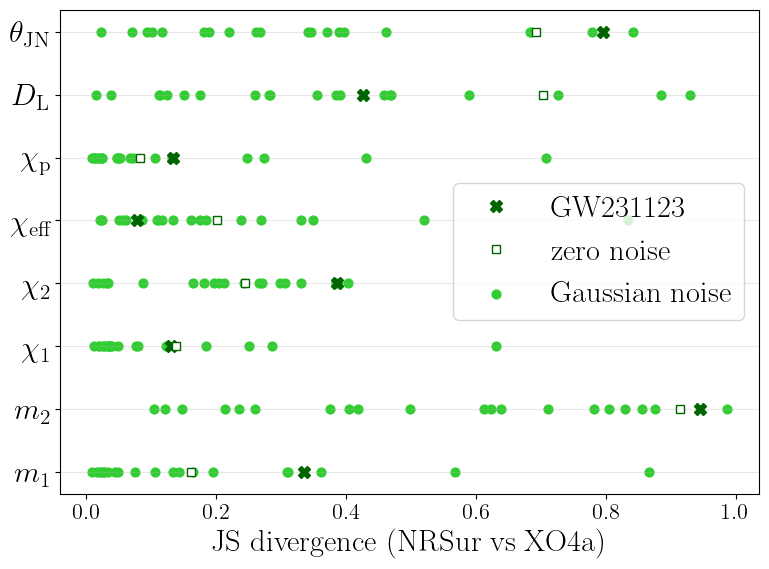

In [13]:
# NRSUR and XO4a
from matplotlib.font_manager import FontProperties
fp = FontProperties(family="STIXGeneral", size=22)          # legend entries

#plot
params = list(divergences_XO4a.keys())
y_positions = np.arange(len(params))  

plt.figure(figsize=(8,6))
plt.grid(axis='y',alpha=0.3)

for i, p in enumerate(params):
    values = divergences_sim_XO4a[p]
    
    plt.plot(divergences_XO4a[p], y_positions[i], 
             'X', color='darkgreen', markersize=8, label='GW231123' if i==0 else "")
    
    plt.plot(divergences_0noise_XO4a[p], y_positions[i], 
             's', color='darkgreen', markersize=6,markerfacecolor='white', label='zero noise' if i==0 else "")

    plt.scatter(values, [y_positions[i]]*len(values), 
                #c=colors, s=40, label='Gaussian noise' if i==0 else "")
                c='limegreen', s=40, label='Gaussian noise' if i==0 else "")

plt.yticks(y_positions, [param_to_str[p] for p in params],fontsize=22)
plt.xlabel("JS divergence (NRSur vs XO4a)", fontsize=22)
plt.legend(prop=fp, fontsize=21)
plt.tight_layout()
plt.show()

### Add visualization of JS

In [14]:
mean1, std1, n1 = 0, 1, 50000     # mean, std, and sample size for Gaussian 1
mean2, std2, n2 = 0, 1, 50000   # mean, std, and sample size for Gaussian 2

mean3, std3, n3 = 9, 1, 50000     # mean, std, and sample size for Gaussian 1
mean4, std4, n4 = 10.43, 1, 50000   # mean, std, and sample size for Gaussian 2

mean5, std5, n5 = 18, 1, 50000     # mean, std, and sample size for Gaussian 1
mean6, std6, n6 = 20.35, 1, 50000   # mean, std, and sample size for Gaussian 2

mean7, std7, n7 = 27, 1, 50000     # mean, std, and sample size for Gaussian 1
mean8, std8, n8 = 30.7, 1, 50000   # mean, std, and sample size for Gaussian 2

# --- Generate random samples ---
data1 = np.random.normal(mean1, std1, n1)
data2 = np.random.normal(mean2, std2, n2)

data3 = np.random.normal(mean3, std3, n3)
data4 = np.random.normal(mean4, std4, n4)

data5 = np.random.normal(mean5, std5, n5)
data6 = np.random.normal(mean6, std6, n6)

data7 = np.random.normal(mean7, std7, n7)
data8 = np.random.normal(mean8, std8, n8)

print(js_divergence_scipy(data1, data2))
print(js_divergence_scipy(data3, data4))
print(js_divergence_scipy(data5, data6))
print(js_divergence_scipy(data7, data8))


0.00010668106486493932
0.29000844748854016
0.5879127848811441
0.8755429429930625


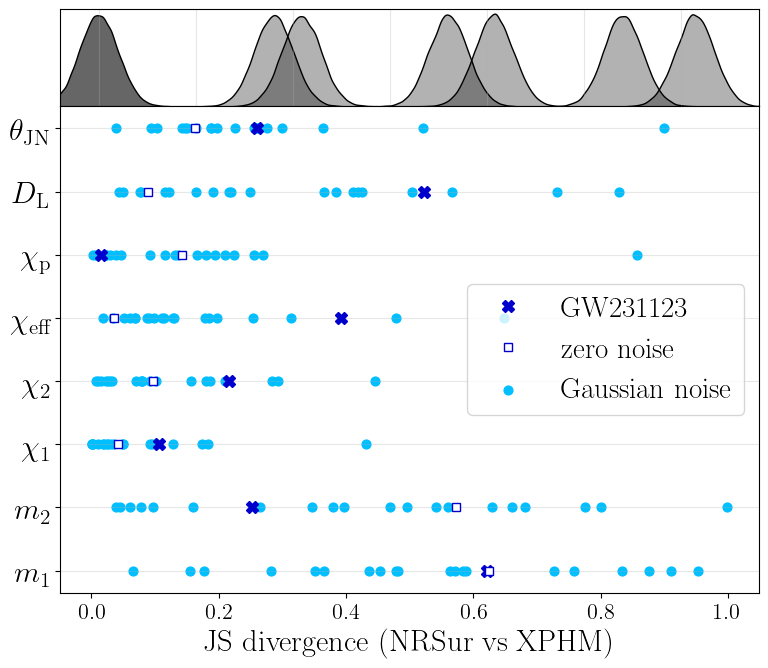

In [15]:
#stack with previous picture
# --- Create combined figure with two panels ---
fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], hspace=0)  # no space

# ===================
# Panel 1: KDE plot
# ===================
ax1 = fig.add_subplot(gs[0])

sns.kdeplot(data1, color='black', alpha=0.6, fill=True, ax=ax1)
sns.kdeplot(data3, color='black', alpha=0.3, fill=True, ax=ax1)
sns.kdeplot(data4, color='black', alpha=0.3, fill=True, ax=ax1)
sns.kdeplot(data5, color='black', alpha=0.3, fill=True, ax=ax1)
sns.kdeplot(data6, color='black', alpha=0.3, fill=True, ax=ax1)
sns.kdeplot(data7, color='black', alpha=0.3, fill=True, ax=ax1)
sns.kdeplot(data8, color='black', alpha=0.3, fill=True, ax=ax1)

ax1.set_xlim(-2, 34)
ax1.set_yticks([])
ax1.set_ylabel('')
ax1.grid(alpha=0.3)
ax1.set_xlabel('')  # remove x-label
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # hide x ticks

# ===================
# Panel 2: JS divergence plot
# ===================
ax2 = fig.add_subplot(gs[1])  # share x-axis for alignment
ax2.grid(axis='y', alpha=0.3)

for i, p in enumerate(params):
    values = divergences_sim[p]
    ax2.plot(divergences[p], y_positions[i], 'X', color='mediumblue', markersize=8, label='GW231123' if i == 0 else "")
    ax2.plot(divergences_0noise[p], y_positions[i], 's', color='mediumblue', markersize=6, markerfacecolor='white', label='zero noise' if i == 0 else "")
    ax2.scatter(values, [y_positions[i]] * len(values), c='deepskyblue', s=40, label='Gaussian noise' if i == 0 else "")

ax2.set_yticks(y_positions)
ax2.set_yticklabels([param_to_str[p] for p in params], fontsize=22)
ax2.set_xlabel("JS divergence (NRSur vs XPHM)", fontsize=22)
ax2.legend(fontsize=21, loc='best')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()